## 10p twitter api

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import csv
from twython import Twython
from twython import TwythonStreamer
import pandas as pd
import numpy as np
from collections import Counter
from pandasql import sqldf

In [2]:
APP_KEY = 'APP_key'
APP_SECRET = 'APP_secret'
twitter = Twython(APP_KEY, APP_SECRET)

In [4]:
text = []
favorites_count = []
retweets_count = []
date = []
local = []

for i in range(0, 17):
    user_timeline = twitter.get_user_timeline(screen_name="RedSox", count=200, include_rts=False)
for tweets in user_timeline:
    favorites_count.append(tweets['favorite_count'])
    retweets_count.append(tweets['retweet_count'])
    date.append(tweets['created_at'])
    text.append(tweets['text'].encode('utf-8'))
    local.append(tweets['geo'])

In [5]:
RedSoxdf = pd.DataFrame({"Favorites" : favorites_count,
    "Retweets" : retweets_count,
    "Date" : date,
    "Text": text, "Coordinates" : local})

RedSoxdf.head()

,Coordinates,Date,Favorites,Retweets,Text
0,None,Mon Oct 10 03:17:42 +0000 2016,1,0,"b""@__HelloKelly__ There's that silver lining!"""
1,None,Mon Oct 10 03:15:19 +0000 2016,0,0,b'@tazachusetts08 Game 4 is now scheduled for ...
2,None,Mon Oct 10 03:13:15 +0000 2016,1,0,b'@partiss38 Hmmm... Maybe!?'
3,None,Mon Oct 10 03:08:45 +0000 2016,0,0,"b""@RugezMatt5 Hi Matt, unfortunately Game 3 ti..."
4,None,Mon Oct 10 00:49:41 +0000 2016,491,130,"b""FYI: The #RedSox are 26-13 in postseason gam..."


## Create second data frame (df2) with out responses and text

In [6]:
non_resp = """SELECT substr(Date, 12, 2) as Hour, Favorites, Retweets
                FROM RedSoxdf
                WHERE Favorites > 30
                AND Retweets > 30
                GROUP BY Hour"""
df2 = pd.DataFrame(sqldf(non_resp, locals()))
df2.head();

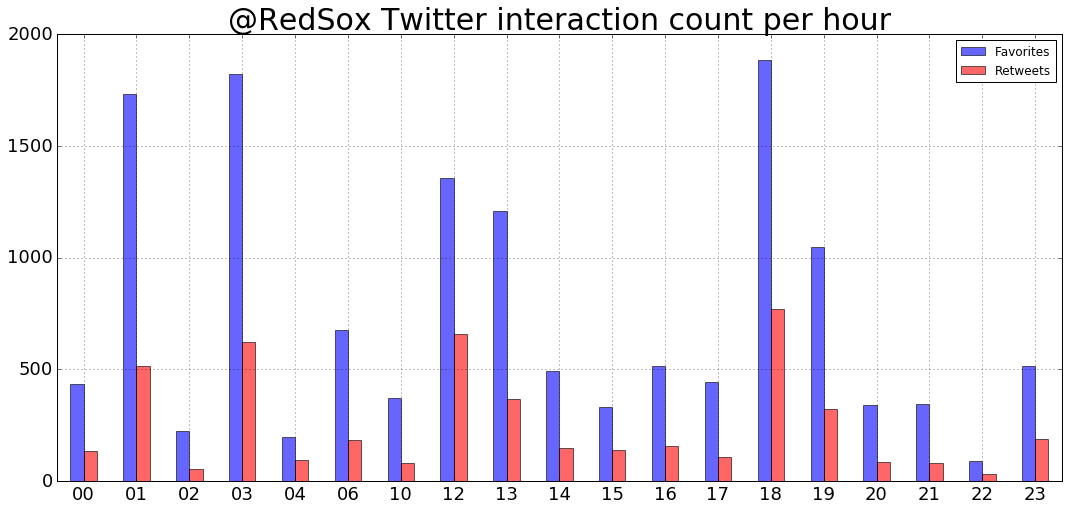

In [112]:
df2.plot(df2['Hour'], kind= 'bar', colormap = 'bwr', alpha = .6, grid = 'on', figsize = (18,8), rot = 0)
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.xlabel("")
plt.title('@RedSox Twitter interaction count per hour', size = 30)
plt.show()

## Breakdown by day

In [15]:
# Subset by day
day = """SELECT substr(Date, 12, 2) as Hour, 
                substr(Date, 4, 7) as Day, Favorites, Retweets
                FROM RedSoxdf
                WHERE Favorites > 30
                AND Retweets > 30
                GROUP BY Hour
                ORDER BY Day"""
df3 = pd.DataFrame(sqldf(day, locals()))
df3;

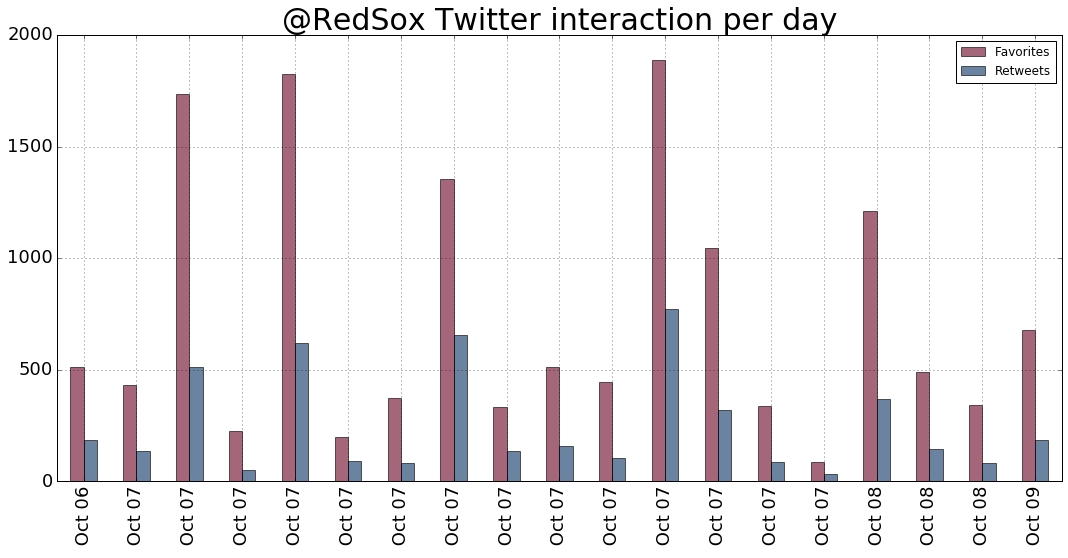

In [113]:
df3.plot(df3['Day'], kind= 'bar', colormap = 'RdBu', alpha = .6, grid = 'on', figsize = (18,8))
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.xlabel("")
plt.title('@RedSox Twitter interaction per day', size = 30)
plt.show()

In [29]:
# locate oct 6
# Subset by day
oct_09 = """SELECT substr(Date, 12, 2) as Hour, Favorites, Retweets
                FROM RedSoxdf
                WHERE Favorites > 30
                AND Retweets > 30
                AND substr(Date, 4, 7) LIKE '%Oct 09%'
                GROUP BY Hour"""
oct_9df = pd.DataFrame(sqldf(oct_09, locals()))
oct_9df;

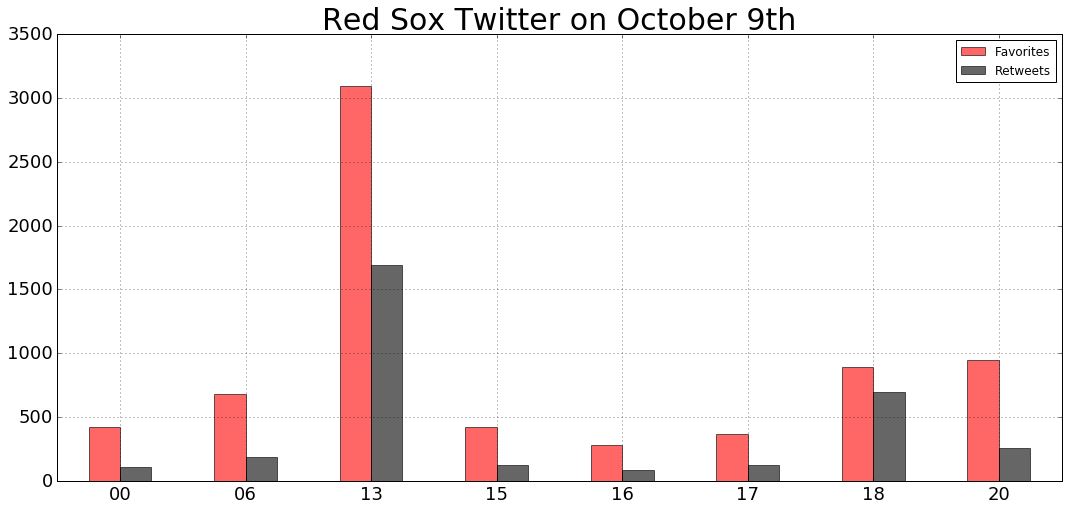

In [114]:
oct_9df.plot(oct_9df['Hour'], kind= 'bar', colormap = 'flag', alpha = .6, grid = 'on', figsize = (18,8), rot = 0)
plt.title('Red Sox Twitter on October 9th', size = 30)
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.xlabel('')
plt.show()

## Text mining tweets on October 9th at 1pm
What is the sentiment in the 13th hour of October 9th that led to this spike?

In [37]:
oct9 = """SELECT substr(Date, 12, 2) as Hour, Favorites, Retweets, Text, Date
                FROM RedSoxdf
                WHERE Favorites > 30
                AND Retweets > 30
                AND substr(Date, 4, 7) LIKE '%Oct 09%'
                AND Hour = '13'
                GROUP BY Hour"""
oct9_text = pd.DataFrame(sqldf(oct9, locals()))
oct9_text

,Hour,Favorites,Retweets,Text,Date
0,13,3096,1692,b'This is it. Today we #WinDanceRepeat. https:...,Sun Oct 09 13:01:46 +0000 2016


In [42]:
import re
oct9string = ''.join(str(e) for e in text)
oct9string = re.sub(r"<a\S+", "", oct9string)
cleanoct9string = str(re.sub('\W+',',', oct9string))
keys = cleanoct9string.split(",")

In [43]:
word_counts = {}
for word in keys:
    word = word.lower()
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

In [45]:
filteroct9 = {k: v for k, v in word_counts.items() if v > 7}

In [69]:
stopwords = ['x80','x83','x8a','x8c',
            'x8d','x8e','x8f','x91',
            'x92','x93','x94','x9a',
            'x9c','x9f','xa3','xa6',
            'xaa','xb8','xba','xbe',
            'xe2','xef','xf0','a',
            'all','amp','are','as',
            'at','b','back','be',
            'been','but','can','co','n',
            'now','of','off','on','our',
            'out', 'and', 't', 's', 
            'https', 'the', 'for', 'in', 
            'is', 'it', 'to', 'The', 'We',
            'this', 'with', 'you', 'that', 
            'there', 'your', 're']


# build a list of keys (badword) that need removing, then remove them.
# http://stackoverflow.com/questions/5447494/best-way-to-remove-an-item-from-a-python-dictionary

keys_to_remove = [key for key, value in filteroct9.items()
                  if key in stopwords]
for key in keys_to_remove:
    del filteroct9[key]

In [70]:
filteroct9;

In [71]:
# Transform the dictionary filteroct6 into a pandas data frame in order to plot
dict_df = pd.DataFrame([filteroct9])
dict_df = dict_df.T
dict_df["Words"] = dict_df.index
dict_df;

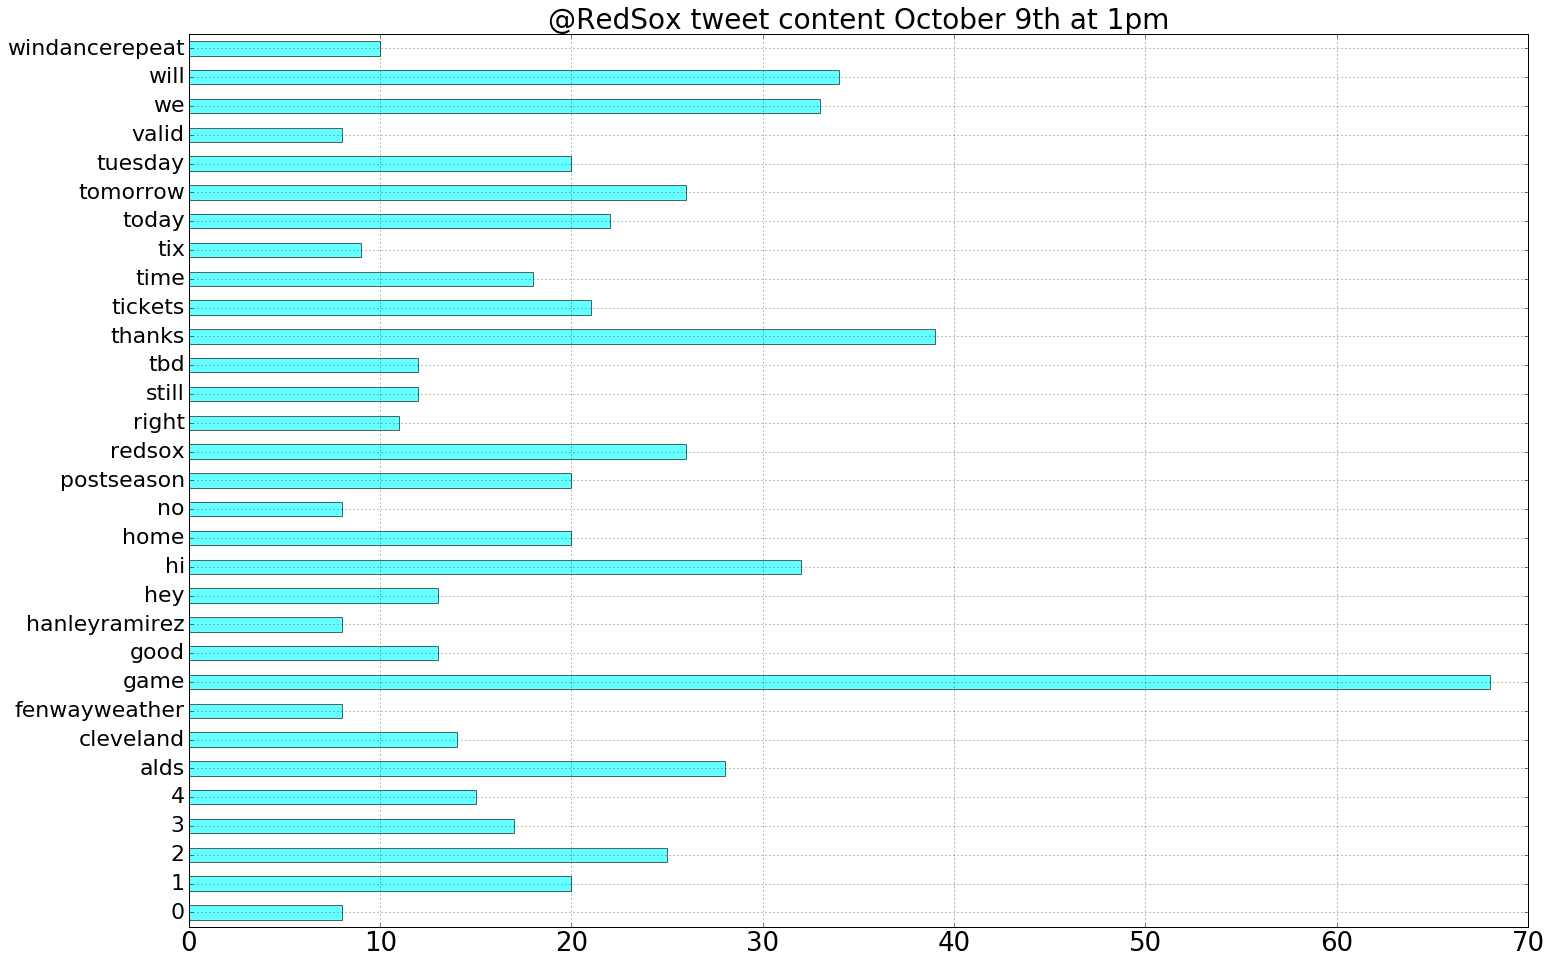

In [119]:
# plot the new df generated from dictionary
dict_df.plot(dict_df['Words'], kind= 'barh', colormap = 'cool', alpha = .6, grid = 'on', figsize = (24,16), legend = False, rot=0)
plt.ylabel('count of word occurrence')
plt.yticks(size = 22)
plt.xticks(size = 26)
plt.ylabel("")
plt.title('@RedSox tweet content October 9th at 1pm', size = 28)
plt.show()

In [ ]:
# ** matplotlib Alternative to above ---- Not as clean ** 
'''
plt.figure(figsize=(12, 8))
top20 = dict(Counter(filteroct6).most_common(20))
plt.bar(range(len(top20)), top20.values(), orientation='vertical')
plt.xticks(range(len(top20)), top20.keys(), rotation=90)
plt.title('Red Sox Twenty Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Counts')'''

## Chicago Cubs twitter

In [89]:
text = []
favorites_count = []
retweets_count = []
date = []
local = []

for i in range(0, 17):
    user_timeline = twitter.get_user_timeline(screen_name="Cubs", count=200, include_rts=False)
for tweets in user_timeline:
    favorites_count.append(tweets['favorite_count'])
    retweets_count.append(tweets['retweet_count'])
    date.append(tweets['created_at'])
    text.append(tweets['text'].encode('utf-8'))
    local.append(tweets['coordinates'])

In [90]:
Cubsdf = pd.DataFrame({"Favorites" : favorites_count,
    "Retweets" : retweets_count,
    "Date" : date,
    "Text": text, "Coordinates" : local})

Cubsdf.head()

,Coordinates,Date,Favorites,Retweets,Text
0,None,Mon Oct 10 03:23:05 +0000 2016,2535,969,b'On deck. https://t.co/uDORoU5UER'
1,None,Mon Oct 10 03:18:54 +0000 2016,9,2,b'@CoachKetcham #FlyTheW https://t.co/L93t0tryP5'
2,None,Mon Oct 10 03:09:40 +0000 2016,4,1,b'@DeLordschips Always. #FlyTheW https://t.co/...
3,None,Mon Oct 10 03:08:57 +0000 2016,4,2,b'@DannyWiser https://t.co/EfWAK5WU7Z'
4,None,Mon Oct 10 03:04:33 +0000 2016,8,3,b'@minapark https://t.co/Jp7e7RR1MR'


In [91]:
# Subset by day
cubs1 = """SELECT substr(Date, 12, 2) as Hour, 
                substr(Date, 4, 7) as Day, Favorites, Retweets
                FROM Cubsdf
                WHERE Favorites > 30
                AND Retweets > 30
                GROUP BY Hour
                ORDER BY Hour"""
cubs_df1 = pd.DataFrame(sqldf(cubs1, locals()))
cubs_df1.head();

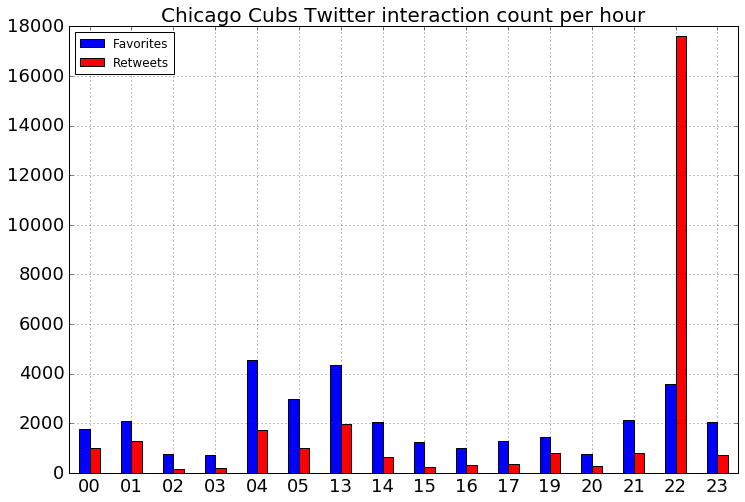

In [107]:
cubs_df1.plot(cubs_df1['Hour'], kind= 'bar', alpha = 1, colormap = "bwr", grid = 'on', figsize = (12,8), rot = 0)
# plt.ylabel('Total')
plt.title('Chicago Cubs Twitter interaction count per hour', size = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.xlabel("")
plt.show()

## Tampa Bay Rays twitter

In [97]:
text = []
favorites_count = []
retweets_count = []
date = []

for i in range(0, 17):
    user_timeline = twitter.get_user_timeline(screen_name="RaysBaseball", count=200, include_rts=False)
for tweets in user_timeline:
    favorites_count.append(tweets['favorite_count'])
    retweets_count.append(tweets['retweet_count'])
    date.append(tweets['created_at'])
    text.append(tweets['text'].encode('utf-8'))

In [98]:
raysdf = pd.DataFrame({"Favorites" : favorites_count,
    "Retweets" : retweets_count,
    "Date" : date,
    "Text": text})

raysdf.head();

In [99]:
# Subset by day
rays1 = """SELECT substr(Date, 12, 2) as Hour, 
                substr(Date, 4, 7) as Day, Favorites, Retweets
                FROM raysdf
                WHERE Favorites > 10
                AND Retweets > 10
                GROUP BY Hour
                ORDER BY Hour"""
rays_df1 = pd.DataFrame(sqldf(rays1, locals()))
rays_df1.head();

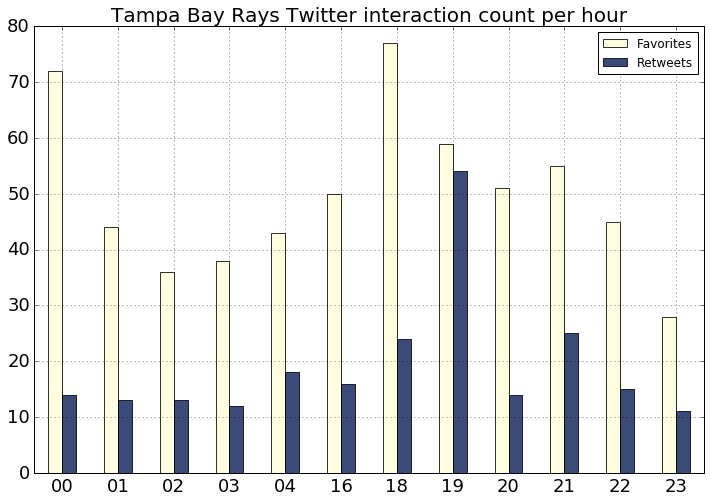

In [106]:
rays_df1.plot(rays_df1['Hour'], kind= 'bar', alpha = .8, colormap = "YlGnBu", grid = 'on', figsize = (12,8), rot = 0)
# plt.ylabel('Total')
plt.title('Tampa Bay Rays Twitter interaction count per hour', size = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.xlabel("")
plt.show()